In [ ]:
# Gerekli kütüphaneler
pip install torch torchvision
pip install numpy
pip install pandas
pip install pillow
pip install opencv-python
pip install matplotlib

In [20]:
import os
import math
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

In [21]:
class SKU110KDataset(Dataset):
    def __init__(self, csv_file, images_root, img_size=512):
        self.df = pd.read_csv(csv_file, header=None)
        self.df.columns = ["image_name","x1","y1","x2","y2","class","w","h"]

        self.images_root = images_root
        self.img_size = img_size

        self.grouped = self.df.groupby("image_name")
        self.image_names = list(self.grouped.groups.keys())

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        rows = self.grouped.get_group(image_name)

        img_path = os.path.join(self.images_root, image_name)

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[WARN] Skipping corrupted image: {img_path} ({e})")
            return self.__getitem__((idx + 1) % len(self))

        orig_w = float(rows["w"].iloc[0])
        orig_h = float(rows["h"].iloc[0])

        img = self.transform(img)

        boxes_np = rows[["x1","y1","x2","y2"]].values.astype("float32")
        sx = self.img_size / orig_w
        sy = self.img_size / orig_h

        boxes_np[:, 0] *= sx 
        boxes_np[:, 2] *= sx  
        boxes_np[:, 1] *= sy  
        boxes_np[:, 3] *= sy  

        boxes = torch.tensor(boxes_np, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64) 

        target = {"boxes": boxes, "labels": labels}
        return img, target

In [22]:
def collate_fn(batch):
    imgs = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return imgs, targets

def box_iou(boxes1, boxes2):
    area1 = (boxes1[:,2] - boxes1[:,0]).clamp(min=0) * (boxes1[:,3] - boxes1[:,1]).clamp(min=0)
    area2 = (boxes2[:,2] - boxes2[:,0]).clamp(min=0) * (boxes2[:,3] - boxes2[:,1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])   
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  
    wh = (rb - lt).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]

    union = area1[:, None] + area2 - inter
    iou = inter / union.clamp(min=1e-6)
    return iou


def encode_boxes(anchors, gt_boxes):
    ax = (anchors[:, 0] + anchors[:, 2]) * 0.5
    ay = (anchors[:, 1] + anchors[:, 3]) * 0.5
    aw = (anchors[:, 2] - anchors[:, 0]).clamp(min=1e-6)
    ah = (anchors[:, 3] - anchors[:, 1]).clamp(min=1e-6)

    gx = (gt_boxes[:, 0] + gt_boxes[:, 2]) * 0.5
    gy = (gt_boxes[:, 1] + gt_boxes[:, 3]) * 0.5
    gw = (gt_boxes[:, 2] - gt_boxes[:, 0]).clamp(min=1e-6)
    gh = (gt_boxes[:, 3] - gt_boxes[:, 1]).clamp(min=1e-6)

    tx = (gx - ax) / aw
    ty = (gy - ay) / ah
    tw = torch.log(gw / aw)
    th = torch.log(gh / ah)

    return torch.stack([tx, ty, tw, th], dim=1)

def decode_boxes(anchors, deltas):
    ax = (anchors[:, 0] + anchors[:, 2]) * 0.5
    ay = (anchors[:, 1] + anchors[:, 3]) * 0.5
    aw = (anchors[:, 2] - anchors[:, 0]).clamp(min=1e-6)
    ah = (anchors[:, 3] - anchors[:, 1]).clamp(min=1e-6)

    tx = deltas[:, 0]
    ty = deltas[:, 1]
    tw = deltas[:, 2]
    th = deltas[:, 3]

    gx = tx * aw + ax
    gy = ty * ah + ay
    gw = aw * torch.exp(tw)
    gh = ah * torch.exp(th)

    x1 = gx - 0.5 * gw
    y1 = gy - 0.5 * gh
    x2 = gx + 0.5 * gw
    y2 = gy + 0.5 * gh

    return torch.stack([x1, y1, x2, y2], dim=1)

In [23]:
class ResNet18Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        m = models.resnet18(weights=None) 

        self.stem = nn.Sequential(
            m.conv1,
            m.bn1,
            m.relu,
            m.maxpool
        )
        self.layer1 = m.layer1  # 64ch
        self.layer2 = m.layer2  # 128ch
        self.layer3 = m.layer3  # 256ch
        self.layer4 = m.layer4  # 512ch

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [24]:
class RetinaHead(nn.Module):
    def __init__(self, in_channels=256, num_anchors=9, num_classes=1):
        super().__init__()
        self.num_anchors = num_anchors
        self.num_classes = num_classes

        cls_layers = []
        for _ in range(4):
            cls_layers.append(nn.Conv2d(in_channels, 256, 3, padding=1))
            cls_layers.append(nn.ReLU())
        self.cls_subnet = nn.Sequential(*cls_layers)
        self.cls_logits = nn.Conv2d(256, num_anchors * num_classes, 3, padding=1)

        reg_layers = []
        for _ in range(4):
            reg_layers.append(nn.Conv2d(in_channels, 256, 3, padding=1))
            reg_layers.append(nn.ReLU())
        self.reg_subnet = nn.Sequential(*reg_layers)
        self.bbox_pred = nn.Conv2d(256, num_anchors * 4, 3, padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        nn.init.constant_(self.cls_logits.bias, -math.log((1 - 0.01) / 0.01))

    def forward(self, feat):
        cls = self.cls_subnet(feat)
        cls = self.cls_logits(cls) 

        reg = self.reg_subnet(feat)
        reg = self.bbox_pred(reg) 

        B, AC, H, W = cls.shape
        _, A4, _, _ = reg.shape
        A = self.num_anchors

        cls = cls.permute(0, 2, 3, 1).contiguous().view(B, H * W * A, self.num_classes)
        reg = reg.permute(0, 2, 3, 1).contiguous().view(B, H * W * A, 4)
        return cls, reg, (H, W)


In [25]:
def generate_anchors(H, W, stride, device, scales=(32, 64, 128), ratios=(0.5, 1.0, 2.0)):
    anchors = []
    shifts_x = (torch.arange(W, device=device) + 0.5) * stride
    shifts_y = (torch.arange(H, device=device) + 0.5) * stride
    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)

    for scale in scales:
        for ratio in ratios:
            area = scale * scale
            w = math.sqrt(area * ratio)
            h = math.sqrt(area / ratio)
            x1 = shift_x - 0.5 * w
            y1 = shift_y - 0.5 * h
            x2 = shift_x + 0.5 * w
            y2 = shift_y + 0.5 * h
            anchors.append(torch.stack([x1, y1, x2, y2], dim=1))

    anchors = torch.cat(anchors, dim=0) 
    return anchors


def focal_loss_binary(logits, targets, alpha=0.25, gamma=2.0):
    prob = torch.sigmoid(logits)
    ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    pt = prob * targets + (1 - prob) * (1 - targets)
    loss = alpha * (1 - pt) ** gamma * ce
    return loss.mean()


def compute_loss(cls_logits, bbox_reg, anchors, targets):
    device = cls_logits.device
    B, A, _ = cls_logits.shape

    cls_targets = torch.zeros((B, A, 1), device=device)
    reg_targets = torch.zeros((B, A, 4), device=device)
    pos_mask = torch.zeros((B, A), dtype=torch.bool, device=device)
    neg_mask = torch.zeros((B, A), dtype=torch.bool, device=device)

    for b in range(B):
        gt_boxes = targets[b]["boxes"].to(device)
        if gt_boxes.numel() == 0:
            neg_mask[b] = True
            continue

        ious = box_iou(anchors, gt_boxes) 
        max_iou, max_idx = ious.max(dim=1)

        pos = max_iou >= 0.5
        neg = max_iou < 0.4

        pos_mask[b] = pos
        neg_mask[b] = neg

        cls_targets[b, pos, 0] = 1.0

        matched_gt = gt_boxes[max_idx]  
        reg_targets[b] = encode_boxes(anchors, matched_gt)

    valid_mask = (pos_mask | neg_mask).unsqueeze(-1) 
    valid_logits = cls_logits[valid_mask].view(-1)
    valid_targets = cls_targets[valid_mask].view(-1)

    if valid_logits.numel() == 0:
        cls_loss = torch.tensor(0.0, device=device)
    else:
        cls_loss = focal_loss_binary(valid_logits, valid_targets)

    if pos_mask.any():
        reg_pred = bbox_reg[pos_mask]   
        reg_tgt  = reg_targets[pos_mask] 
        reg_loss = F.smooth_l1_loss(reg_pred, reg_tgt, reduction="mean")
    else:
        reg_loss = torch.tensor(0.0, device=device)

    total_loss = cls_loss + reg_loss
    return {"loss": total_loss, "cls_loss": cls_loss, "reg_loss": reg_loss}

In [26]:
@torch.no_grad()
def quick_inference_preview(model, image_path, img_size=512,
                            score_thresh=0.3):

    model.eval()
    device = next(model.parameters()).device

    orig_img = Image.open(image_path).convert("RGB")
    orig_w, orig_h = orig_img.size

    resized_img = orig_img.resize((img_size, img_size))
    img_tensor = torch.tensor(np.array(resized_img)).permute(2,0,1).float() / 255.
    img_tensor = img_tensor.unsqueeze(0).to(device)

    scores, bbox_reg, anchors = model([img_tensor[0]])

    scores = scores[0,:,0]
    boxes  = decode_boxes(anchors, bbox_reg[0])

    keep = scores > score_thresh
    scores = scores[keep]
    boxes  = boxes[keep]

    sx = orig_w / img_size
    sy = orig_h / img_size

    boxes[:, [0,2]] *= sx
    boxes[:, [1,3]] *= sy

    boxes = boxes.detach().cpu().numpy()
    scores = scores.detach().cpu().numpy()

    img_cv = cv2.cvtColor(np.array(orig_img), cv2.COLOR_RGB2BGR)

    for b, s in zip(boxes, scores):
        x1,y1,x2,y2 = b.astype(int)

        cv2.rectangle(img_cv, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img_cv, f"{s:.2f}", (x1, y1-4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

In [27]:
class RetinaNet18(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.backbone = ResNet18Backbone()
        self.reduce = nn.Conv2d(512, 256, kernel_size=1)
        self.head = RetinaHead(in_channels=256, num_anchors=9, num_classes=num_classes)

    def forward(self, images, targets=None):
        x = torch.stack(images, dim=0)  
        feat = self.backbone(x)         
        feat = self.reduce(feat)        

        cls_logits, bbox_reg, (Hf, Wf) = self.head(feat)

        B = x.size(0)
        img_size = x.shape[-1]  
        stride = img_size / Hf  
        device = x.device

        anchors = generate_anchors(Hf, Wf, stride, device=device)  

        if targets is not None:
            loss_dict = compute_loss(cls_logits, bbox_reg, anchors, targets)
            return loss_dict
        else:
            scores = cls_logits.sigmoid()
            return scores, bbox_reg, anchors

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, targets in dataloader:
        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(imgs, targets)
        loss = loss_dict["loss"]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


@torch.no_grad()
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    for imgs, targets in dataloader:
        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = loss_dict["loss"]
        total_loss += loss.item()

    return total_loss / len(dataloader)

Device: cuda
En iyi model yukleniyor

Epoch 1/1
Train Loss: 0.0231
Val   Loss: 0.0223
LR: 0.000100
Yeni en iyi model kaydedildi	(val_loss = 0.0223)

Egitim tamamlandi
Validation loss: 0.0223


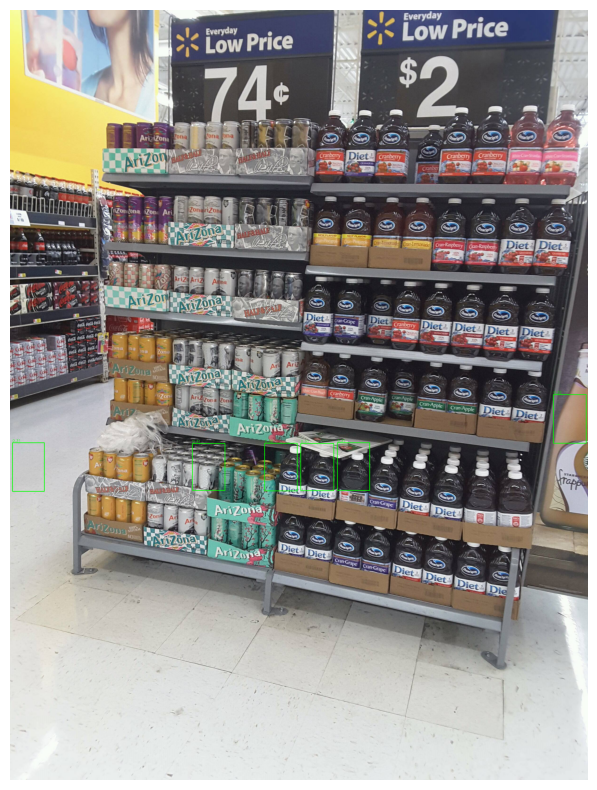

In [ ]:
def main():
    # -----------------------------------------------
    csv_file    = r"SKU110K_fixed\annotations\annotations_train.csv"
    images_root = r"\SKU110K_fixed\images"
    img_size    = 512
    # -----------------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    dataset = SKU110KDataset(csv_file, images_root, img_size=img_size)

    val_ratio = 0.2
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,
                              num_workers=0, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False,
                              num_workers=0, collate_fn=collate_fn)

    model = RetinaNet18(num_classes=1).to(device)

    if os.path.exists("best_model.pth"):
        print("En iyi model yukleniyor")
        state = torch.load("best_model.pth", map_location=device)
        model.load_state_dict(state, strict=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=10,
        gamma=0.3
    )

    num_epochs = 1
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss   = validate(model, val_loader, device)

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val   Loss: {val_loss:.4f}")
        print(f"LR: {current_lr:.6f}")

        lr_scheduler.step()


        torch.save(model.state_dict(), "last_model.pth")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Yeni en iyi model kaydedildi\t(val_loss = {val_loss:.4f})")

    print("\nEgitim tamamlandi")
    print(f"Validation loss: {best_val_loss:.4f}")


    sample_img_name = val_ds[0][0] 
    img_path = os.path.join(images_root, val_ds.dataset.image_names[val_ds.indices[0]])

    quick_inference_preview(model, img_path)


if __name__ == "__main__":
    main()